## **Installing packages**

In [1]:
!pip3 install torch torchvision torchaudio torchsummary
!pip install 'tqdm'

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.1 MB/s eta 0:00:00


In [4]:
!pip install thop

## **Libraries**

In [5]:
import os
import os.path
import sys
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, Dataset
from torch.backends import cudnn
import torch.cuda.amp as amp
from torch.autograd import Function
import torch.nn.functional as F

import torchvision
from torchvision.transforms import transforms
import torchvision.transforms.functional as fun

from PIL import Image
from tqdm import tqdm
import numpy as np
from tensorboardX import SummaryWriter

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random

from pathlib import Path
import json
import random

from torchsummary import summary
from thop import profile


logger = logging.getLogger()

## **Import**

### Importing datasets

In [ ]:
from google.colab import drive

drive.mount('/content/Drive')

cityscapes = True
gta5 = True

if not os.path.isdir(f'/content/Cityscapes') and cityscapes:
  !jar xvf  "/content/Drive/MyDrive/Colab Notebooks/AML/Cityscapes.zip"
if not os.path.isdir(f'/content/GTA5') and gta5:
  !jar xvf  "/content/Drive/MyDrive/Colab Notebooks/AML/GTA5.zip"

Output streaming troncato alle ultime 5000 righe.
 inflated: GTA5/images/00002.png
 inflated: GTA5/images/00003.png
 inflated: GTA5/images/00004.png
 inflated: GTA5/images/00005.png
 inflated: GTA5/images/00006.png
 inflated: GTA5/images/00007.png
 inflated: GTA5/images/00008.png
 inflated: GTA5/images/00009.png
 inflated: GTA5/images/00010.png
 inflated: GTA5/images/00011.png
 inflated: GTA5/images/00012.png
 inflated: GTA5/images/00013.png
 inflated: GTA5/images/00014.png
 inflated: GTA5/images/00015.png
 inflated: GTA5/images/00016.png
 inflated: GTA5/images/00017.png
 inflated: GTA5/images/00018.png
 inflated: GTA5/images/00019.png
 inflated: GTA5/images/00020.png
 inflated: GTA5/images/00021.png
 inflated: GTA5/images/00022.png
 inflated: GTA5/images/00023.png
 inflated: GTA5/images/00024.png
 inflated: GTA5/images/00025.png
 inflated: GTA5/images/00026.png
 inflated: GTA5/images/00027.png
 inflated: GTA5/images/00028.png
 inflated: GTA5/images/00029.png
 inflated: GTA5/images/000

### Import methods from TA's repository (STDC-net)

In [6]:
# cloning github repo for model (STDC-net) and utils, we rewrote manually the Train.py and Cityscapes.py below
import pathlib
print(pathlib.Path.cwd())
!git clone https://github.com/ClaudiaCuttano/AML_Semantic_DA.git


# importing stuff from the repo we just cloned

from AML_Semantic_DA.model.model_stages import BiSeNet
from AML_Semantic_DA.utils import poly_lr_scheduler, reverse_one_hot, compute_global_accuracy, fast_hist, per_class_iu

/content
Cloning into 'AML_Semantic_DA'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
Receiving objects: 100% (18/18), 10.88 KiB | 1.36 MiB/s, done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 9


### Import BiSeNet v1
Clone our GitHub repo: https://github.com/ivanmag22/Semantic_Segmentation_project

In [7]:
# cloning github repo for model (BiseNet v1) and utils
import pathlib
print(pathlib.Path.cwd())
!git clone https://github.com/ivanmag22/Semantic_Segmentation_project.git


# importing stuff from the repo we just cloned

from Semantic_Segmentation_project.model.bisenetv1 import BiSeNet as BiSeNetv1

/content
Cloning into 'Semantic_Segmentation_project'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 85 (delta 4), reused 15 (delta 4), pack-reused 70
Receiving objects: 100% (85/85), 221.75 MiB | 21.21 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (12/12), done.


### Import methods for BiSeNet, Cityscapes and GTA5
Clone repo useful to give a label for each pixel.

In [8]:
import pathlib
print(pathlib.Path.cwd())
!git clone https://github.com/MichaelFan01/STDC-Seg.git STDC_seg

/content
Cloning into 'STDC_seg'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 98 (delta 18), reused 8 (delta 8), pack-reused 70
Receiving objects: 100% (98/98), 1.93 MiB | 4.49 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## **Data loader classes + Preprocessing**

### Data Pre Processing
We need to do pre-processing only on **training set** (and not on validation set because on the last one we work with 1024 x 2048 pictures)

In [ ]:
train_transform = transforms.Compose([transforms.Resize((512,1024), transforms.InterpolationMode.BILINEAR),
                                      transforms.ToTensor()
                                      ])
label_transform = transforms.Resize((512,1024), transforms.InterpolationMode.NEAREST)
eval_transform = transforms.Compose([transforms.ToTensor()])


gta_train_transform = transforms.Compose([transforms.Resize((512,1024), transforms.InterpolationMode.BILINEAR),
                                          transforms.ToTensor()
                                          ])
gta_label_transform = transforms.Resize((512,1024), transforms.InterpolationMode.NEAREST)
gta_val_transform = transforms.Compose([transforms.ToTensor()])


#data augmentation
bright_t = transforms.ColorJitter(brightness=[1,2])
contrast_t = transforms.ColorJitter(contrast = [2,5])
saturation_t = transforms.ColorJitter(saturation = [1,3])
hue_t = transforms.ColorJitter(hue = 0.2)
gs_t = transforms.Grayscale(3)
hflip_t = transforms.RandomHorizontalFlip(p = 1)
cc_t = transforms.CenterCrop((256,512))

augmentation_transforms = [bright_t, contrast_t, saturation_t, hue_t, gs_t, hflip_t, cc_t]

### Cityscapes

In [ ]:
class CityScapes(Dataset):
    def __init__(self, base_root, mode):
        super(CityScapes, self).__init__()

        self.mode = mode
        self.image_paths = [] # images
        self.mask_paths_colored = [] # colored images
        self.mask_paths_bw = [] # labels

        assert(mode == 'train' or mode == 'val')  # just checking for potential issues
        image_folder = f'{base_root}images/{mode}'

        for root, dirs, files in os.walk(image_folder):
            for file_name in files:
                image_path = f'{root}/{file_name}'
                assert(Path(image_path).is_file())
                self.image_paths.append(image_path)

                mask_path_bw = image_path.replace('leftImg8bit', 'gtFine_labelTrainIds')
                mask_path_bw = mask_path_bw.replace('/images/', '/gtFine/')
                assert(Path(mask_path_bw).is_file())
                self.mask_paths_bw.append(mask_path_bw)

        if self.mode == 'train':
            self.image_transform = train_transform
        if self.mode == 'val':
            self.image_transform = eval_transform
        self.label_transform = label_transform

        assert (len(self.image_paths) != 0)
        assert (len(self.image_paths) == len(self.mask_paths_bw))


    def __getitem__(self, index):

        image = Image.open(self.image_paths[index]).convert('RGB')
        label = Image.open(self.mask_paths_bw[index])

        if self.mode == 'train':
            label = np.array(self.label_transform(label))[np.newaxis, :]
        else:
            label = np.array(label)[np.newaxis, :]

        image = self.image_transform(image)

        return image, label


    def __len__(self):
        return len(self.image_paths)

### GTA5

In [ ]:
class GTA5(Dataset):
    def __init__(self, base_root, mode, augmentation=False, train_test_rateo=2/3):
        super(GTA5, self).__init__()

        self.mode = mode
        self.image_paths = [] # images
        self.label_paths = [] # labels
        self.train_test_rateo = train_test_rateo
        self.augmentation = augmentation
        with open('STDC_seg/cityscapes_info.json', 'r') as fr:
            labels_info = json.load(fr)
        self.label_map = {el['id']: el['trainId'] for el in labels_info}
        self.label_map.update({34 : 255})

        assert(mode == 'train' or mode == 'val')  # just checking for potential issues

        image_folder = f'{base_root}images'

        for root, dirs, files in os.walk(image_folder):
            for file_name in files:
                image_path = f'{root}/{file_name}'
                assert(Path(image_path).is_file())
                self.image_paths.append(image_path)

                label_path = image_path.replace('/images/', '/labels/')
                assert(Path(label_path).is_file())
                self.label_paths.append(label_path)

        l = int(len(self.image_paths) * self.train_test_rateo)
        if self.mode == 'train':
            self.image_paths = self.image_paths[:l]
            self.label_paths = self.label_paths[:l]
            self.image_transform = gta_train_transform
            self.label_transform = gta_label_transform
        elif self.mode == 'val':
            self.image_paths = self.image_paths[l:]
            self.label_paths = self.label_paths[l:]
            self.image_transform = gta_val_transform

        assert (len(self.image_paths) != 0)
        assert (len(self.image_paths) == len(self.label_paths))


    def __getitem__(self, index):

        image = Image.open(self.image_paths[index]).convert('RGB')
        image = self.image_transform(image)

        label = Image.open(self.label_paths[index])
        if self.mode == 'train':
            label = self.label_transform(label)

        if self.augmentation and random.choice([True, False]) and self.mode == 'train':
            idx = random.randint(0, 6)

            image = augmentation_transforms[idx](image)

            if hflip_t is augmentation_transforms[idx] or cc_t is augmentation_transforms[idx]:
                label = augmentation_transforms[idx](label)

            if cc_t is augmentation_transforms[idx]:
                rimage_t = transforms.Resize((512,1024), transforms.InterpolationMode.BILINEAR, antialias=None)
                rlabel_t = transforms.Resize((512,1024), transforms.InterpolationMode.NEAREST, antialias=None)
                image = rimage_t(image)
                label = augmentation_transforms[idx](label)
                label = rlabel_t(label)

        label = np.array(label).astype(np.int64)[np.newaxis, :]
        label = self.convert_labels(label)

        return image, label


    def convert_labels(self, label):
        for k, v in self.label_map.items():
            label[label == k] = v
        return label


    def __len__(self):
        return len(self.image_paths)


## **Discriminators**
- *FCDiscriminator*: standard discriminator
- *LightFCDiscriminator*: discriminator with depth pointwise convolutional layers
- *LightLightFCDiscriminator*: like the previous discriminator, but with three convolutional layers

In [9]:
class DepthWiseSeparableConvolution(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(DepthWiseSeparableConvolution, self).__init__()
        self.depth_wise = nn.Conv2d(ch_in, ch_in, kernel_size=4, stride=2, padding=1, groups=ch_in)
        self.point_wise = nn.Conv2d(ch_in, ch_out, kernel_size=1)

    def forward(self, x):
        out = self.depth_wise(x)
        out = self.point_wise(out)
        return out

class LightFCDiscriminator(nn.Module):
    def __init__(self, num_classes, ndf=64):
        super(LightFCDiscriminator, self).__init__()

        # context
        self.conv1 = DepthWiseSeparableConvolution(num_classes, ndf)
        self.conv2 = DepthWiseSeparableConvolution(ndf, ndf*2)
        self.conv3 = DepthWiseSeparableConvolution(ndf*2, ndf*4)
        self.conv4 = DepthWiseSeparableConvolution(ndf*4, ndf*8)
        self.classifier = DepthWiseSeparableConvolution(ndf*8, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.up_sample = nn.Upsample(scale_factor=32, mode='bilinear')


    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.classifier(x)
        x = self.up_sample(x)
        return x

class LightLightFCDiscriminator(nn.Module):
    def __init__(self, num_classes, ndf=64):
        super(LightLightFCDiscriminator, self).__init__()

        # context
        self.conv1 = DepthWiseSeparableConvolution(num_classes, ndf)
        self.conv2 = DepthWiseSeparableConvolution(ndf, ndf*2)
        self.classifier = DepthWiseSeparableConvolution(ndf*2, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.up_sample = nn.Upsample(scale_factor=8, mode='bilinear')


    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.classifier(x)
        x = self.up_sample(x)
        return x

class FCDiscriminator(nn.Module):

    def __init__(self, num_classes, ndf = 64):
        super(FCDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(num_classes, ndf, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1)
        self.classifier = nn.Conv2d(ndf*8, 1, kernel_size=4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.up_sample = nn.Upsample(scale_factor=32, mode='bilinear')
        #self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.classifier(x)
        x = self.up_sample(x)
        #x = self.sigmoid(x)

        return x

## **Image and output representation**

In [ ]:
batch_size = 8
num_classes = 19
num_workers = 2

### Load labels and colors

In [ ]:
with open('/content/STDC_seg/cityscapes_info.json', 'r') as fr:
        labels_info = json.load(fr)
cs_map = {el['trainId']: torch.tensor(el['color'])/255 for el in labels_info}
idName_map = {el['trainId']: el['name'] for el in labels_info}
color_map = torch.stack([cs_map[i] for i in cs_map.keys()])

### Mapping color-label

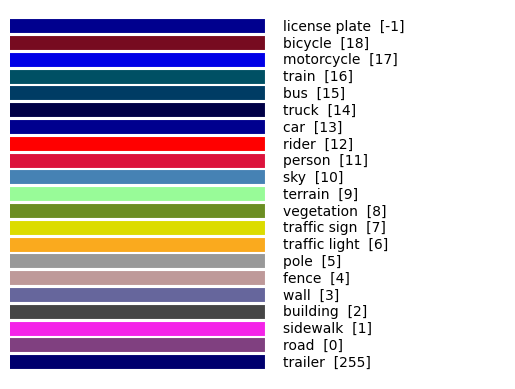

In [ ]:
fig, ax = plt.subplots()

for i, (id, color) in enumerate(cs_map.items()):
    ax.plot([0, 1], [i, i], color=np.array(color), linewidth=10)
    ax.text(1.1, i, f"{idName_map[id]}  [{str(id)}]", va='center')

ax.set_xlim(0, 2)
ax.set_ylim(-1, len(cs_map))
ax.axis('off')

plt.show()

### Model

In [ ]:
backbone = 'CatmodelSmall'
pretrain_model = "/content/Drive/MyDrive/Colab Notebooks/checkpoints/STDCNet813M_73.91.tar"
use_conv_last = False
n_classes = 19
batch_size=8
best_model = True

model = BiSeNet(backbone, n_classes, pretrain_model, use_conv_last)
#model = BiSeNetv1(num_classes=n_classes, context_path='resnet18')

if isinstance(model, BiSeNet) and best_model:
    model.load_state_dict(torch.load('/content/Semantic_Segmentation_project/model/best_models/p3_lr_0001_lrD_00001_bs_8_Saved_model_epoch_50.pth'))
elif isinstance(model, BiSeNetv1) and best_model:
    model.load_state_dict(torch.load('/content/Semantic_Segmentation_project/model/best_models/p4_bisenetv1_domadpt_lightdiscr_BSv1_Best_model_epoch_25.pth'))

model = model.cuda()

use pretrain model /content/Drive/MyDrive/Colab Notebooks/checkpoints/STDCNet813M_73.91.tar


### Cityscapes

In [ ]:
train_root = 'Cityscapes/Cityspaces/'

train_dataset = CityScapes(train_root, 'train')
dataloader_train = DataLoader(train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=num_workers,
                      pin_memory=False,
                      drop_last=True)
train_loader = enumerate(dataloader_train)
_, batch = next(train_loader)
data, label = batch

#### Image

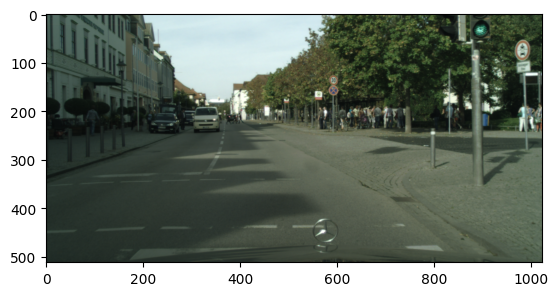

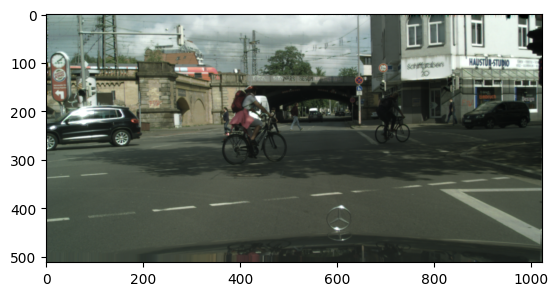

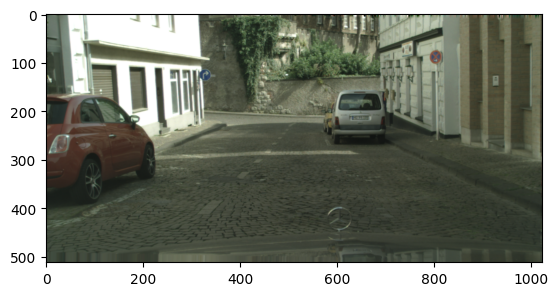

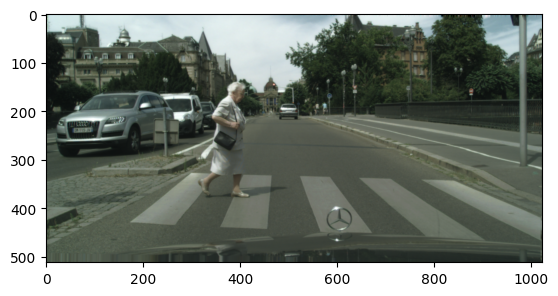

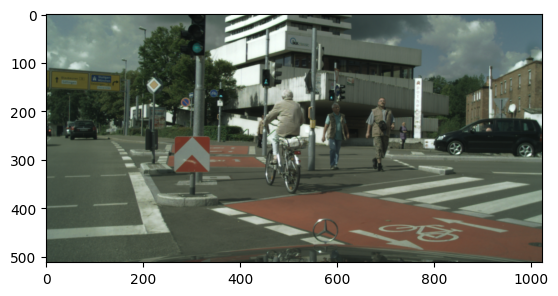

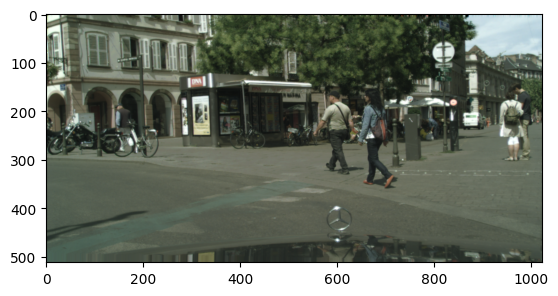

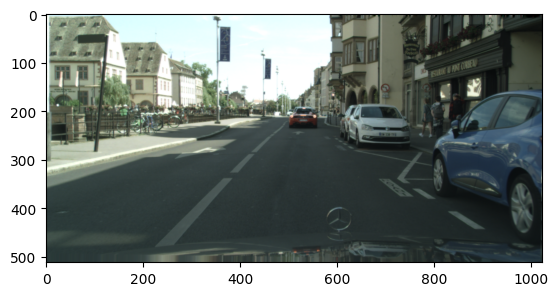

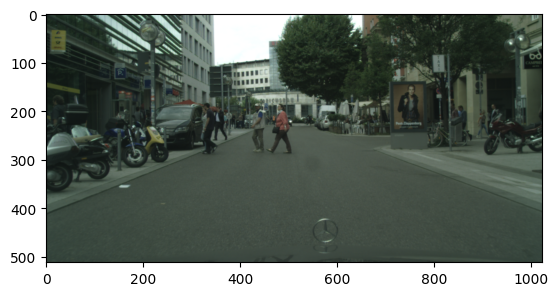

In [ ]:
for image in data:
    img = image.squeeze(0)
    img = fun.to_pil_image(img) # torchvision.transforms.functional.to_pil_image
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_img_{i}.jpg")
    plt.show()

#### Label

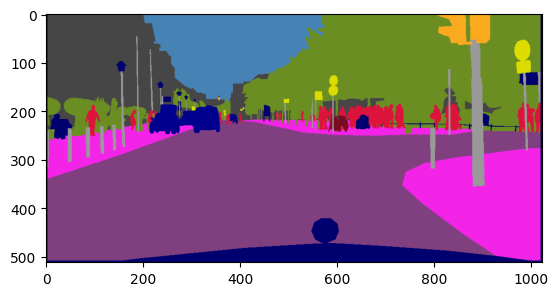

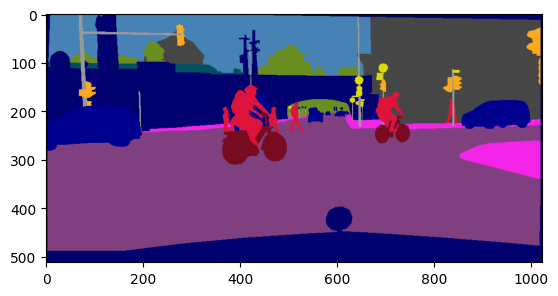

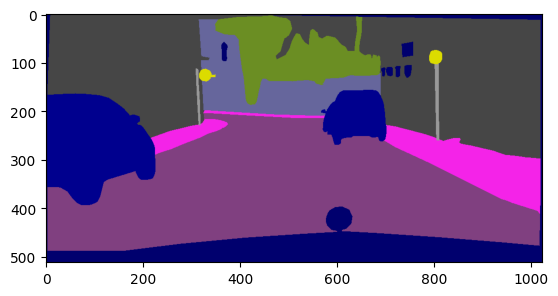

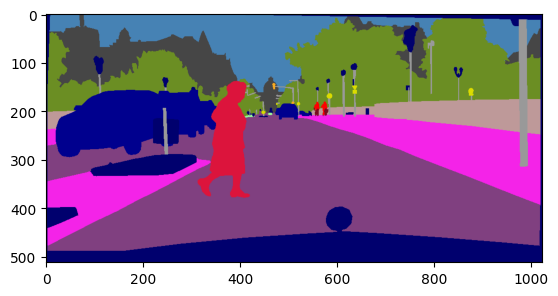

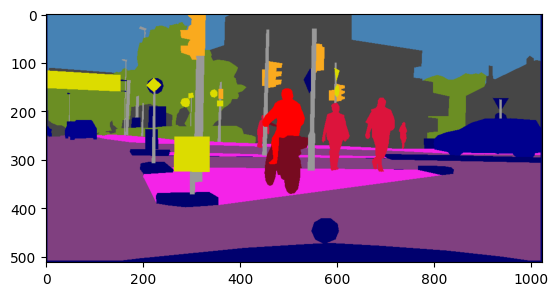

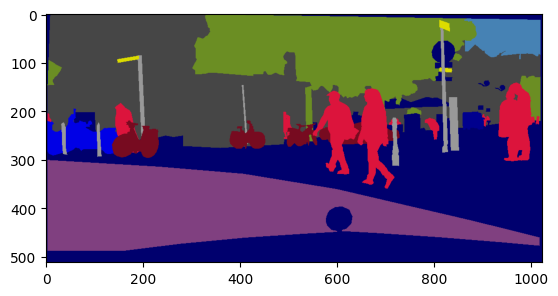

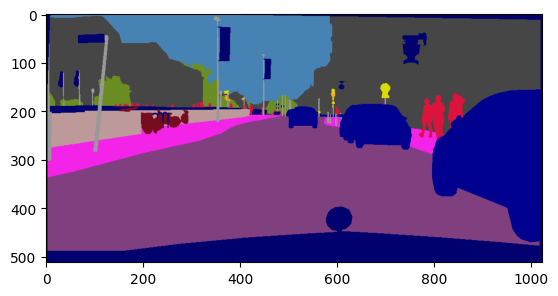

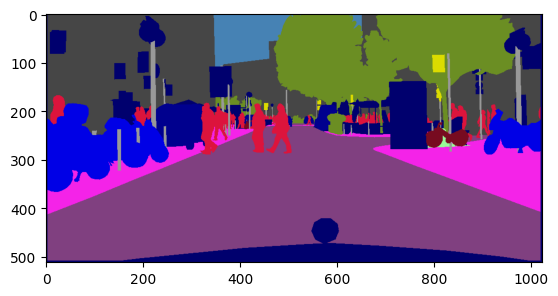

In [ ]:
label = label.squeeze(1)
label_imgs = torch.zeros(8,3,512,1024)

for b in range(label.shape[0]):
    label_imgs[b] = torch.stack([cs_map[label[b, r, c].item()] for r in range(label.shape[1]) for c in range(label.shape[2])], dim=1).reshape(3, 512, 1024)
    img = label_imgs[b].squeeze(0)
    img = fun.to_pil_image(img)
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_out_{i}.jpg")
    plt.show()

#### Output

In [ ]:
data = data.cuda()
output, _, _ = model(data)

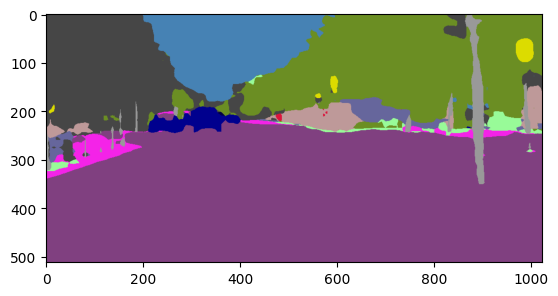

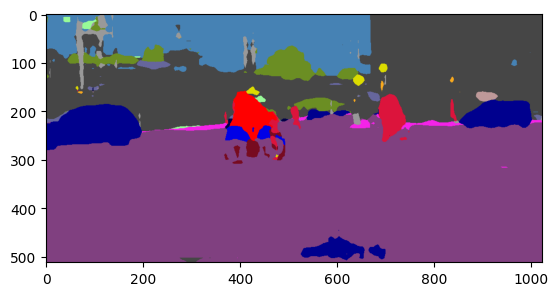

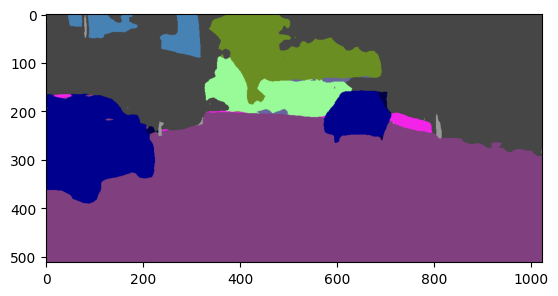

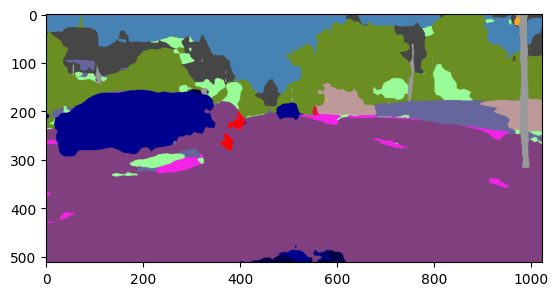

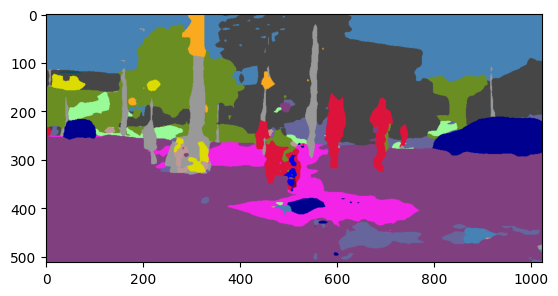

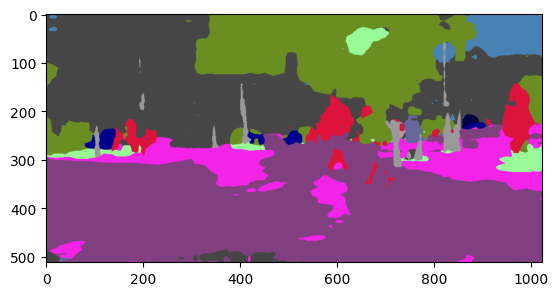

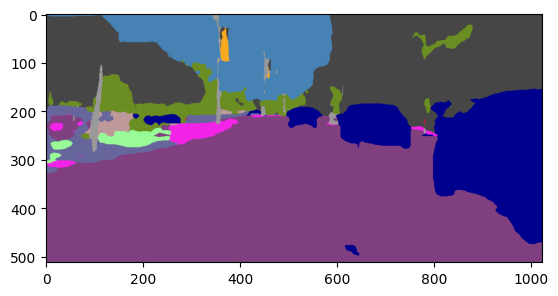

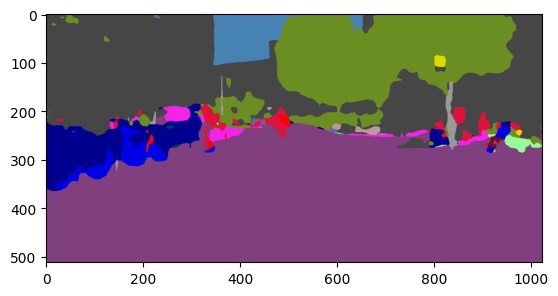

In [ ]:
pred = torch.argmax(output, dim=1)
pred_imgs = torch.zeros(8,3,512,1024)

for b in range(output.shape[0]):
    pred_imgs[b] = torch.stack([cs_map[pred[b, r, c].item()] for r in range(pred.shape[1]) for c in range(pred.shape[2])], dim=1).reshape(3, 512, 1024)
    img = pred_imgs[b].squeeze(0)
    img = fun.to_pil_image(img)
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_out_{i}.jpg")
    plt.show()

### GTA5

In [ ]:
train_root = 'GTA5/'

train_dataset = GTA5(train_root, 'train')
dataloader_train = DataLoader(train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=num_workers,
                      pin_memory=False,
                      drop_last=True)
train_loader = enumerate(dataloader_train)
_, batch = next(train_loader)
data, label = batch

#### Image

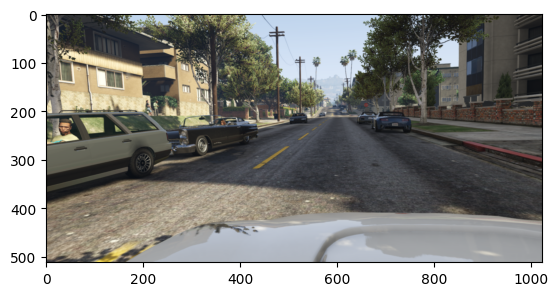

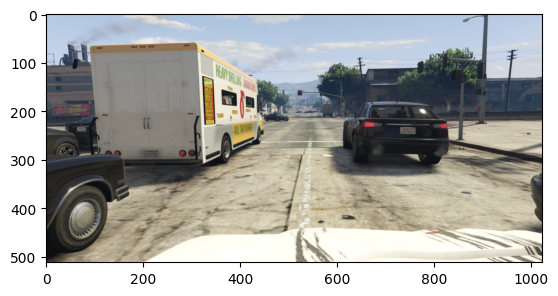

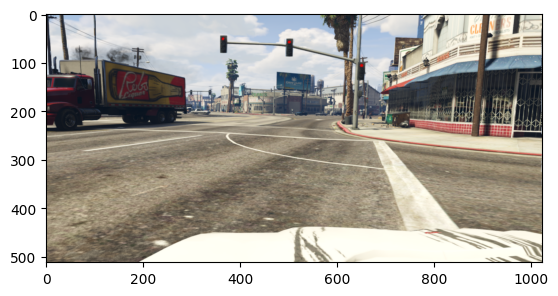

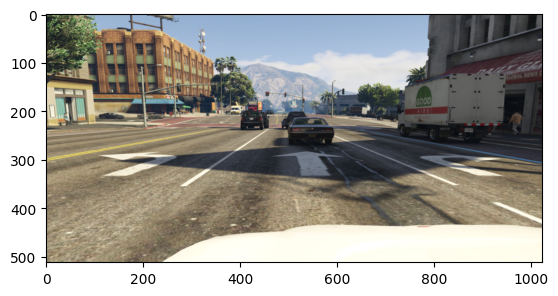

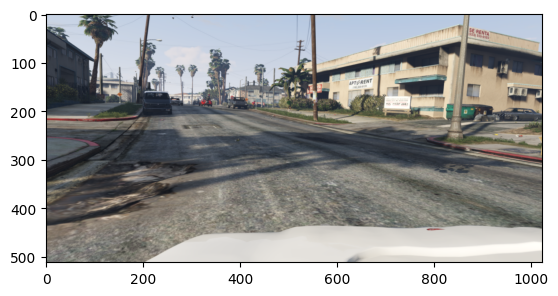

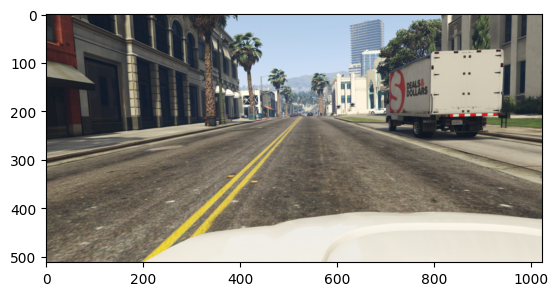

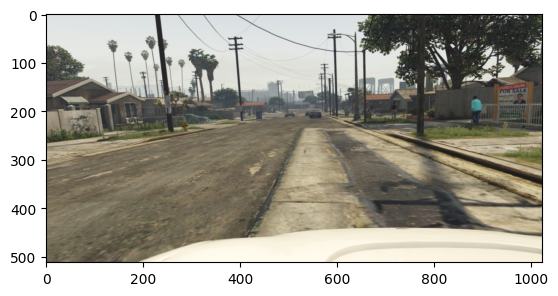

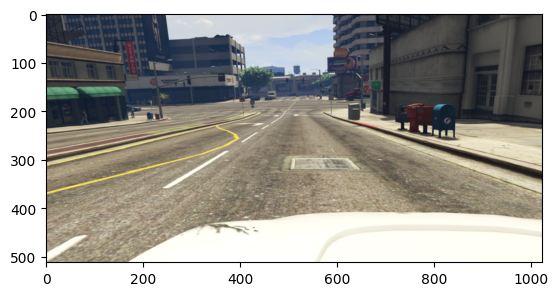

In [ ]:
for image in data:
    img = image.squeeze(0)
    img = fun.to_pil_image(img) # torchvision.transforms.functional.to_pil_image
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_img_{i}.jpg")
    plt.show()

##### Augmented image

In [ ]:
sample_img = data[0].squeeze(0)

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

Transformation:	 ['bright_t', 't']


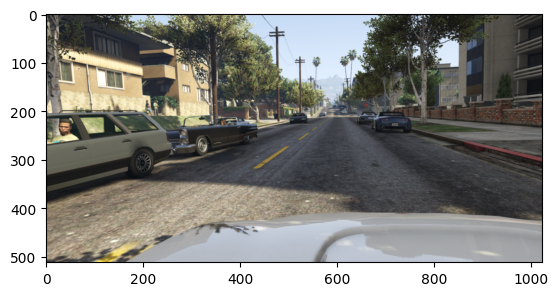

Transformation:	 ['contrast_t', 't']


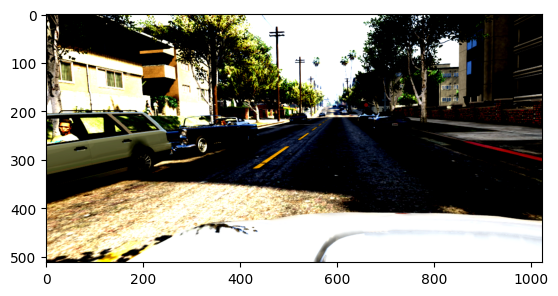

Transformation:	 ['saturation_t', 't']


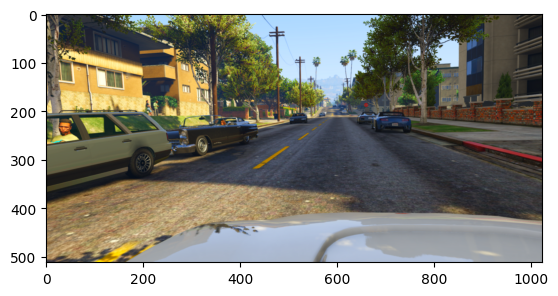

Transformation:	 ['hue_t', 't']


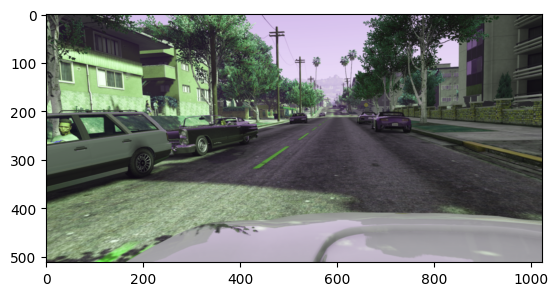

Transformation:	 ['gs_t', 't']


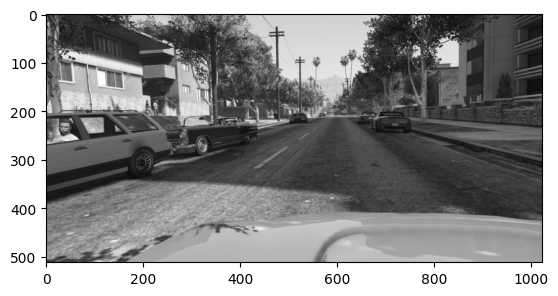

Transformation:	 ['hflip_t', 't']


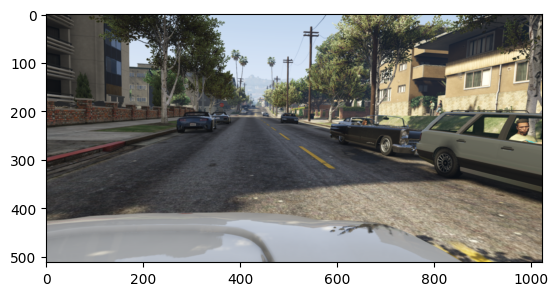

Transformation:	 ['cc_t', 't']


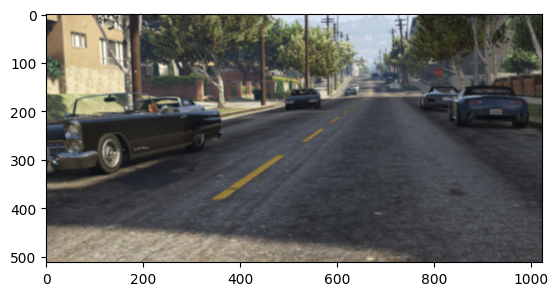

In [ ]:
for t in augmentation_transforms:
    print("Transformation:\t",namestr(t,globals()))
    sample = t(sample_img)
    if t is cc_t:
        rimage_t = transforms.Resize((512,1024), transforms.InterpolationMode.BILINEAR, antialias=None)
        sample = rimage_t(sample)
    img = fun.to_pil_image(sample)
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_img_{i}.jpg")
    plt.show()

#### Label

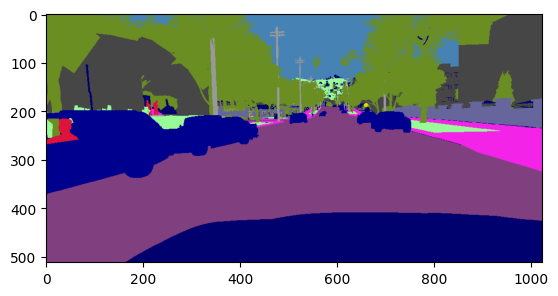

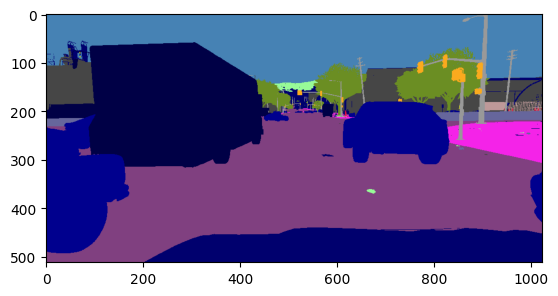

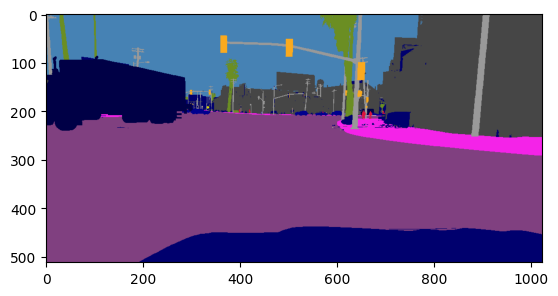

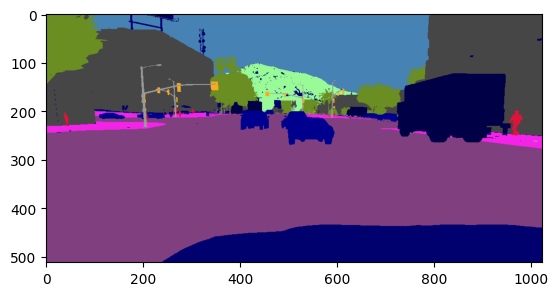

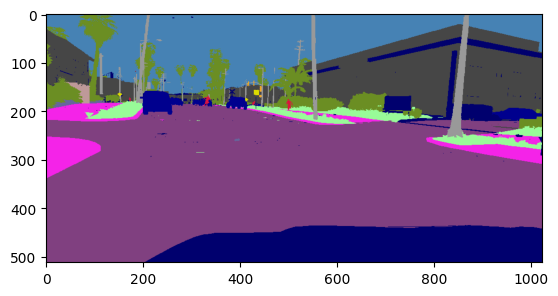

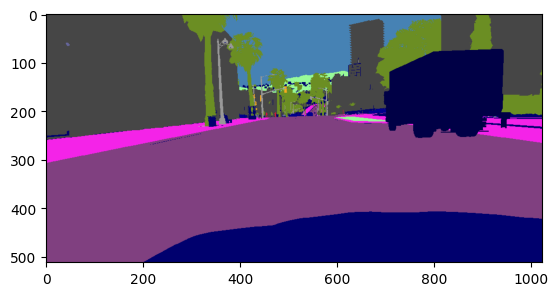

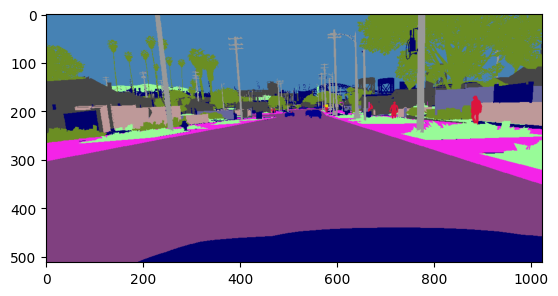

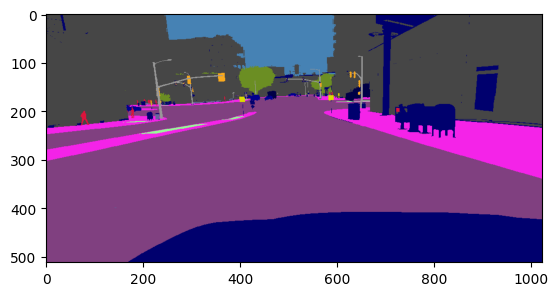

In [ ]:
label = label.squeeze(1)
label_imgs = torch.zeros(8,3,512,1024)

for b in range(label.shape[0]):
    label_imgs[b] = torch.stack([cs_map[label[b, r, c].item()] for r in range(label.shape[1]) for c in range(label.shape[2])], dim=1).reshape(3, 512, 1024)
    img = label_imgs[b].squeeze(0)
    img = fun.to_pil_image(img)
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_out_{i}.jpg")
    plt.show()

##### Augmented label

In [ ]:
label_img = torch.stack([cs_map[label[0, r, c].item()] for r in range(label.shape[1]) for c in range(label.shape[2])], dim=1).reshape(3, 512, 1024)
sample_lbl = label_img.squeeze(0)

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

Transformation:	 ['bright_t', 't']


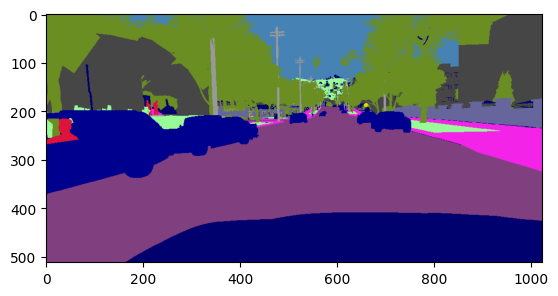

Transformation:	 ['contrast_t', 't']


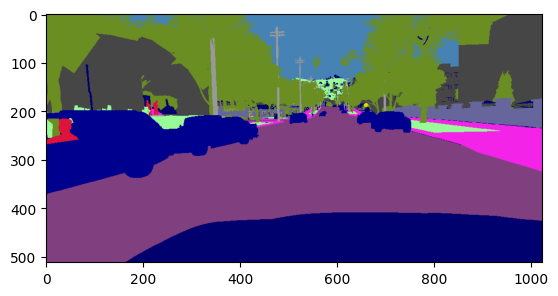

Transformation:	 ['saturation_t', 't']


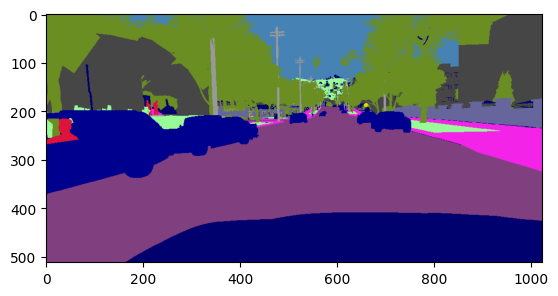

Transformation:	 ['hue_t', 't']


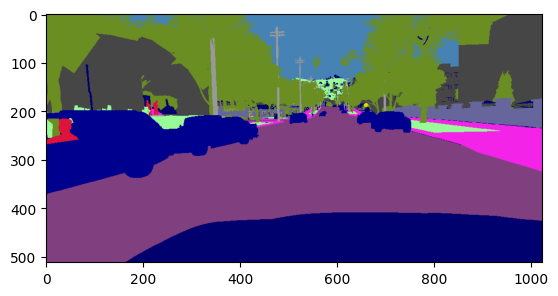

Transformation:	 ['gs_t', 't']


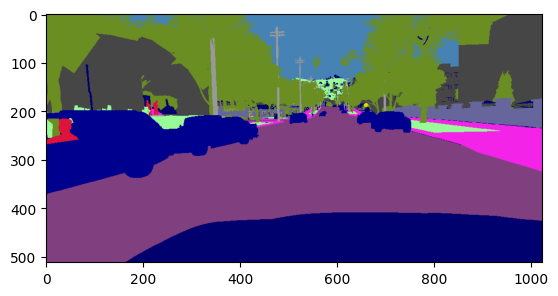

Transformation:	 ['hflip_t', 't']


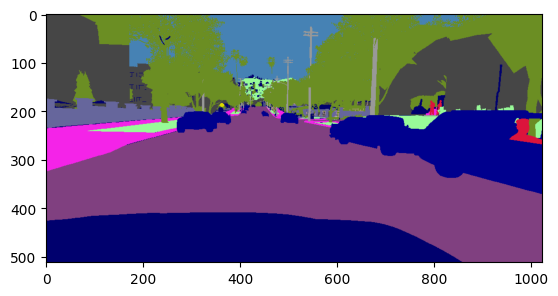

Transformation:	 ['cc_t', 't']


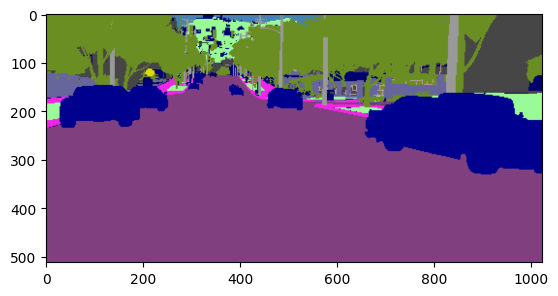

In [ ]:
for t in augmentation_transforms:
    print("Transformation:\t",namestr(t,globals()))
    if t is hflip_t:
        sample_lbl = t(sample_lbl)
    if t is cc_t:
        rlabel_t = transforms.Resize((512,1024), transforms.InterpolationMode.NEAREST, antialias=None)
        sample_lbl = t(sample_lbl)
        sample_lbl = rlabel_t(sample_lbl)
    img = fun.to_pil_image(sample_lbl)
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_img_{i}.jpg")
    plt.show()

#### Output

In [ ]:
data = data.cuda()
output, _, _ = model(data)

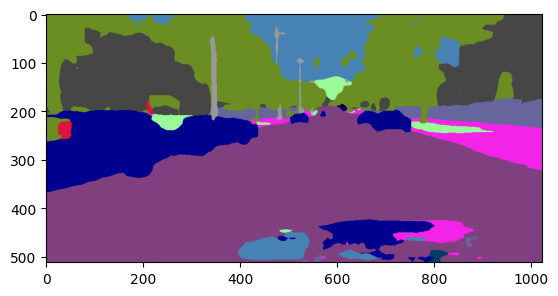

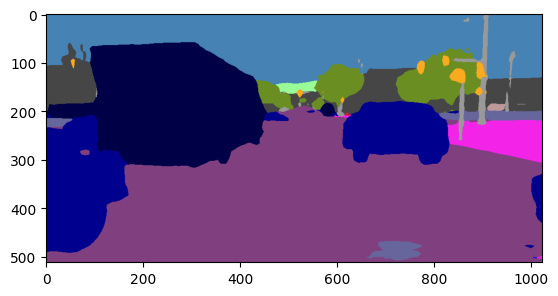

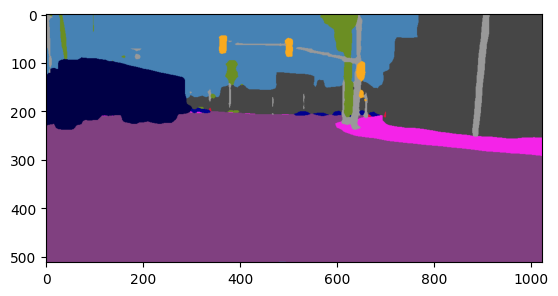

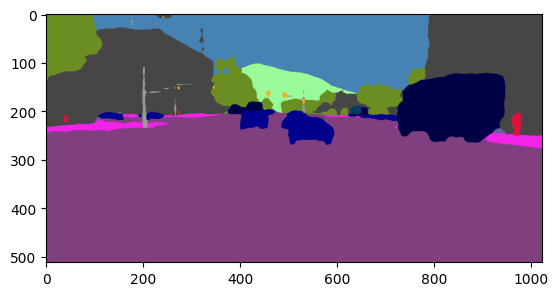

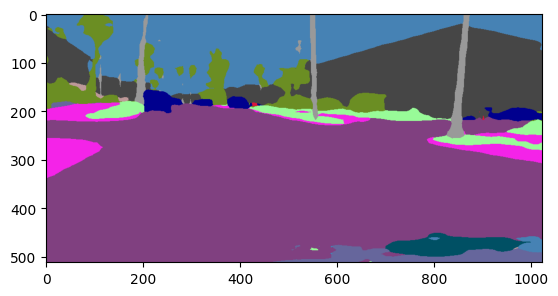

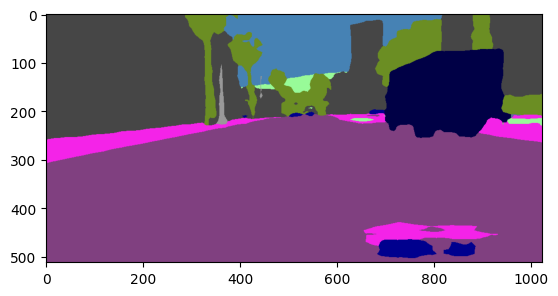

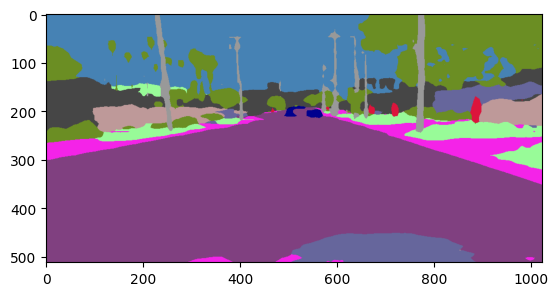

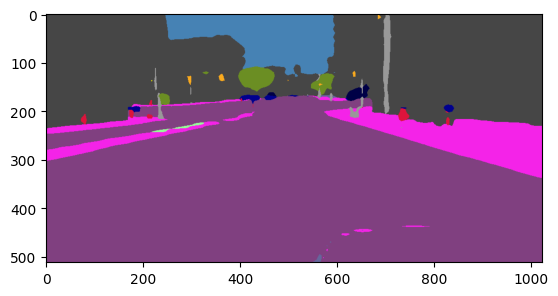

In [ ]:
pred = torch.argmax(output, dim=1)
pred_imgs = torch.zeros(8,3,512,1024)

for b in range(output.shape[0]):
    pred_imgs[b] = torch.stack([cs_map[pred[b, r, c].item()] for r in range(pred.shape[1]) for c in range(pred.shape[2])], dim=1).reshape(3, 512, 1024)
    img = pred_imgs[b].squeeze(0)
    img = fun.to_pil_image(img)
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_out_{i}.jpg")
    plt.show()

##### Output for augmented image

In [ ]:
model.eval()

aug_outputs = []

In [ ]:
for t in augmentation_transforms:
    sample = t(sample_img)
    sample = sample.unsqueeze(0)
    if t is cc_t:
        rimage_t = transforms.Resize((512,1024), transforms.InterpolationMode.BILINEAR, antialias=None)
        sample = rimage_t(sample)
    sample = sample.cuda()
    if isinstance(model, BiSeNet):
        output, _, _ = model(sample)
    else:
        output = model(sample)
    aug_outputs.append(output)

Transformation:	 ['bright_t']


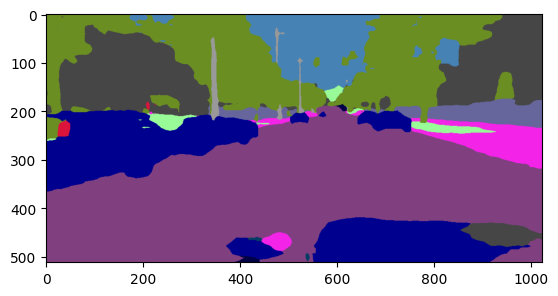

Transformation:	 ['contrast_t']


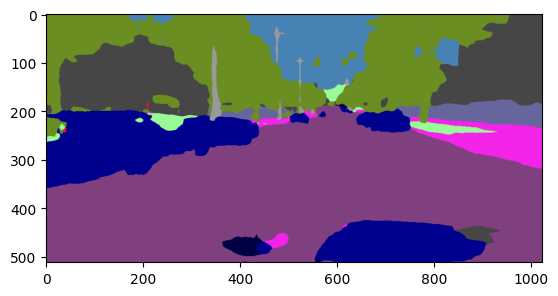

Transformation:	 ['saturation_t']


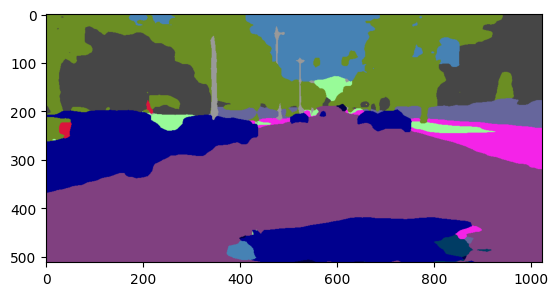

Transformation:	 ['hue_t']


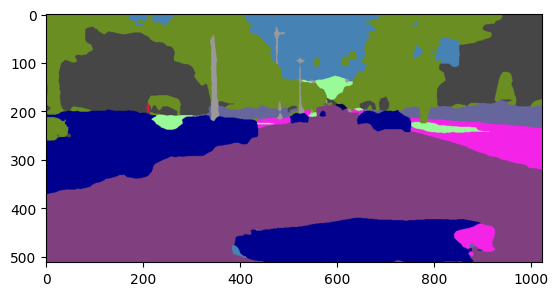

Transformation:	 ['gs_t']


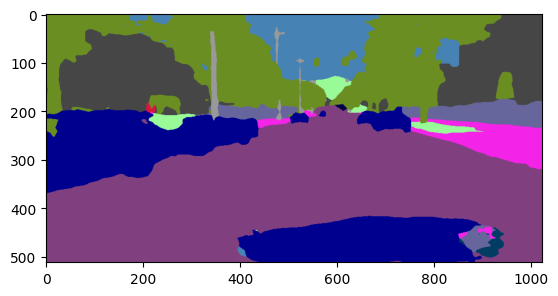

Transformation:	 ['hflip_t']


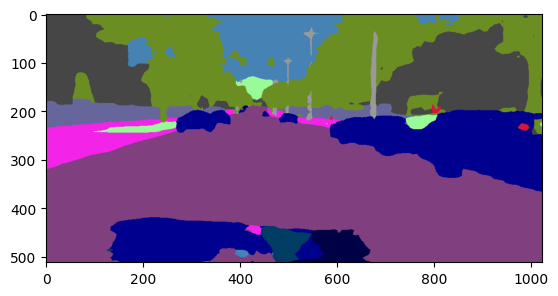

Transformation:	 ['cc_t', 't']


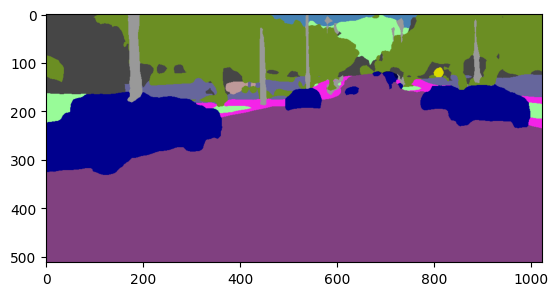

In [ ]:
for i, output in enumerate(aug_outputs):
    print("Transformation:\t",namestr(augmentation_transforms[i],globals()))
    pred = torch.argmax(output, dim=1)
    pred_out = torch.stack([cs_map[pred[0, r, c].item()] for r in range(pred.shape[1]) for c in range(pred.shape[2])], dim=1).reshape(3, 512, 1024)
    img = pred_out.squeeze(0)
    img = fun.to_pil_image(img)
    plt.imshow(np.asarray(img))
    #plt.savefig(f"/content/Drive/MyDrive/Colab Notebooks/images/source_out_{i}.jpg")
    plt.show()

Although there are some little changes due to the transformations, the outputs are still the same (with the exception of horizontal flip and center crop transformations).

See labels in GTA5/Label/Augmented label to compare these results with the corresponding labels.

## **Model metrics**

### *STDC-net*

In [ ]:
backbone = 'CatmodelSmall'
pretrain_model = "/content/Drive/MyDrive/Colab Notebooks/checkpoints/STDCNet813M_73.91.tar"
use_conv_last = False
n_classes = 19
batch_size=8

if not os.path.exists("/content/Drive/"):
    from google.colab import drive

    drive.mount('/content/Drive')

model = BiSeNet(backbone, n_classes, pretrain_model, use_conv_last)

model = model.cuda()

use pretrain model /content/Drive/MyDrive/Colab Notebooks/checkpoints/STDCNet813M_73.91.tar


#### Parameters

In [ ]:
summary(model, (3, 512, 1024), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 512]             864
            Conv2d-2         [-1, 32, 256, 512]             864
       BatchNorm2d-3         [-1, 32, 256, 512]              64
       BatchNorm2d-4         [-1, 32, 256, 512]              64
              ReLU-5         [-1, 32, 256, 512]               0
              ReLU-6         [-1, 32, 256, 512]               0
             ConvX-7         [-1, 32, 256, 512]               0
             ConvX-8         [-1, 32, 256, 512]               0
            Conv2d-9         [-1, 64, 128, 256]          18,432
           Conv2d-10         [-1, 64, 128, 256]          18,432
      BatchNorm2d-11         [-1, 64, 128, 256]             128
      BatchNorm2d-12         [-1, 64, 128, 256]             128
             ReLU-13         [-1, 64, 128, 256]               0
             ReLU-14         [-1, 64, 1

#### MACs

In [ ]:
t = torch.randn((batch_size, 3, 512, 1024)).cuda()
macs, params = profile(model, inputs=(t, ))
print(f"MACs:\t{macs}\nParameters:\t{params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
MACs:	332732575744.0
Parameters:	13743552.0


#### Inference time on GPU

In [ ]:
model = BiSeNet(backbone, n_classes, pretrain_model, use_conv_last)

model = model.cuda()

use pretrain model /content/Drive/MyDrive/Colab Notebooks/checkpoints/STDCNet813M_73.91.tar


In [ ]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
t = torch.randn((1, 3, 1024, 2048)).cuda()
model.eval()
torch.cuda.empty_cache()
with torch.no_grad():
    starter.record()
    _ = model(t)
    ender.record()
# wait for gpu sync
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print(f"Inference time on GPU:\t{curr_time:.3f} ms")

Inference time on GPU:	76.574 ms


##### FPS

In [ ]:
curr_time_sec = curr_time*10**-3
fps = 1/curr_time_sec
print(f"FPS on GPU:\t{fps:.3f}")

FPS on GPU:	13.059


#### Inference time on CPU

In [ ]:
device = torch.device("cpu")

model = BiSeNet(backbone, n_classes, pretrain_model, use_conv_last, device)

use pretrain model /content/Drive/MyDrive/Colab Notebooks/checkpoints/STDCNet813M_73.91.tar


In [ ]:
import time

model.eval()
t = torch.randn((1, 3, 1024, 2048))
curr_time=0
with torch.no_grad():
    start = time.time_ns()
    _ = model(t)
    end = time.time_ns()
curr_time = end-start
print(f"Inference time on CPU:\t{curr_time*10**-6:.3f} ms")

Inference time on CPU:	3671.938 ms


##### FPS

In [ ]:
curr_time_sec = curr_time*10**-9
fps = 1/curr_time_sec
print(f"FPS on CPU:\t{fps:.3f}")

FPS on CPU:	0.272


### *BiSeNet v1*

In [ ]:
num_classes = 19
context_path = "resnet18"

batch_size=8

model = BiSeNetv1(num_classes, context_path)

model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date we

#### Parameters

In [ ]:
summary(model, (3, 512, 1024), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 512]           1,728
       BatchNorm2d-2         [-1, 64, 256, 512]             128
              ReLU-3         [-1, 64, 256, 512]               0
         ConvBlock-4         [-1, 64, 256, 512]               0
            Conv2d-5        [-1, 128, 128, 256]          73,728
       BatchNorm2d-6        [-1, 128, 128, 256]             256
              ReLU-7        [-1, 128, 128, 256]               0
         ConvBlock-8        [-1, 128, 128, 256]               0
            Conv2d-9         [-1, 256, 64, 128]         294,912
      BatchNorm2d-10         [-1, 256, 64, 128]             512
             ReLU-11         [-1, 256, 64, 128]               0
        ConvBlock-12         [-1, 256, 64, 128]               0
     Spatial_path-13         [-1, 256, 64, 128]               0
           Conv2d-14         [-1, 64, 2

#### MACs

In [ ]:
t = torch.randn((batch_size, 3, 512, 1024)).cuda()
macs, params = profile(model, inputs=(t, ))
print(f"MACs:\t{macs}\nParameters:\t{params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MACs:	663658925864.0
Parameters:	23230554.0


#### Inference time on GPU

In [ ]:
model = BiSeNetv1(num_classes, context_path)

model = model.cuda()

In [ ]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
t = torch.randn((1, 3, 1024, 2048)).cuda()
curr_time=0
model.eval()
torch.cuda.empty_cache()
with torch.no_grad():
    starter.record()
    _ = model(t)
    ender.record()
    # wait for gpu sync
    torch.cuda.synchronize()
    curr_time = starter.elapsed_time(ender)
    print(f"Inference time on GPU:\t{curr_time:.3f} ms")

Inference time on GPU:	84.071 ms


##### FPS

In [ ]:
curr_time_sec = curr_time*10**-3
fps = 1/curr_time_sec
print(f"FPS on GPU:\t{fps:.3f}")

FPS on GPU:	11.895


#### Inference time on CPU

In [ ]:
model = BiSeNetv1(num_classes, context_path)

In [ ]:
import time

model.eval()
t = torch.randn((1, 3, 1024, 2048))
curr_time=0

with torch.no_grad():
    start = time.time_ns()
    _ = model(t)
    end = time.time_ns()
    curr_time = end-start
    print(f"Inference time on CPU:\t{curr_time*10**-6:.3f} ms")

Inference time on CPU:	5720.719 ms


##### FPS

In [ ]:
curr_time_sec = curr_time*10**-9
fps = 1/curr_time_sec
print(f"FPS on CPU:\t{fps:.3f}")

FPS on CPU:	0.175


## **Discriminators metrics**

In [10]:
batch_size = 8
num_classes = 19

FC_D = FCDiscriminator(num_classes)
LightFC_D = LightFCDiscriminator(num_classes)
LightThinFC_D = LightLightFCDiscriminator(num_classes)

### FCDiscriminator

In [ ]:
model_D = FC_D.cuda()

#### Parameters

In [ ]:
summary(model_D, (num_classes, 512, 1024), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 512]          19,520
         LeakyReLU-2         [-1, 64, 256, 512]               0
            Conv2d-3        [-1, 128, 128, 256]         131,200
         LeakyReLU-4        [-1, 128, 128, 256]               0
            Conv2d-5         [-1, 256, 64, 128]         524,544
         LeakyReLU-6         [-1, 256, 64, 128]               0
            Conv2d-7          [-1, 512, 32, 64]       2,097,664
         LeakyReLU-8          [-1, 512, 32, 64]               0
            Conv2d-9            [-1, 1, 16, 32]           8,193
         Upsample-10         [-1, 1, 512, 1024]               0
Total params: 2,781,121
Trainable params: 2,781,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 38.00
Forward/backward pass size (MB): 244.00
Params size (MB): 10.61
Est

#### MACs

In [ ]:
t = torch.randn((batch_size, num_classes, 512, 1024)).cuda()
macs, params = profile(model_D, inputs=(t, ))
print(f"MACs:\t{macs}\nParameters:\t{params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
MACs:	123560001536.0
Parameters:	2781121.0


#### Feed-forward time on GPU

In [11]:
model_D = FCDiscriminator(num_classes)
model_D = model_D.cuda()

In [14]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

model_D.eval()
t = torch.randn((1, num_classes, 512, 1024)).cuda()
torch.cuda.empty_cache()
starter.record()
with torch.no_grad():
    _ = model_D(t)
ender.record()
# wait for gpu sync
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print(f"Inference time on GPU:\t{curr_time: .3f} ms")

Inference time on GPU:	 14.508 ms


##### FPS

In [15]:
curr_time_sec = curr_time*10**-3
fps = 1/curr_time_sec
print(f"FPS on GPU:\t{fps:.3f}")

FPS on GPU:	68.926


#### Feed-forward time on CPU

In [16]:
model_D = FCDiscriminator(num_classes)

In [21]:
import time

t = torch.randn((1, num_classes, 512, 1024))
curr_time = 0
with torch.no_grad():
    start = time.time_ns()
    _ = model_D(t)
    end = time.time_ns()
    curr_time = end-start
print(f"Inference time on CPU:\t{curr_time*10**-6:.3f} ms")

Inference time on CPU:	500.530 ms


##### FPS

In [22]:
curr_time_sec = curr_time*10**-9
fps = 1/curr_time_sec
print(f"FPS on CPU:\t{fps:.3f}")

FPS on CPU:	1.998


### LightFCDiscriminator

In [23]:
model_D = LightFC_D.cuda()

#### Parameters

In [ ]:
summary(model_D, (num_classes, 512, 1024), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 19, 256, 512]             323
            Conv2d-2         [-1, 64, 256, 512]           1,280
DepthWiseSeparableConvolution-3         [-1, 64, 256, 512]               0
         LeakyReLU-4         [-1, 64, 256, 512]               0
            Conv2d-5         [-1, 64, 128, 256]           1,088
            Conv2d-6        [-1, 128, 128, 256]           8,320
DepthWiseSeparableConvolution-7        [-1, 128, 128, 256]               0
         LeakyReLU-8        [-1, 128, 128, 256]               0
            Conv2d-9         [-1, 128, 64, 128]           2,176
           Conv2d-10         [-1, 256, 64, 128]          33,024
DepthWiseSeparableConvolution-11         [-1, 256, 64, 128]               0
        LeakyReLU-12         [-1, 256, 64, 128]               0
           Conv2d-13          [-1, 256, 32, 64]           4,352
     

#### MACs

In [ ]:
t = torch.randn((batch_size, num_classes, 512, 1024)).cuda()
macs, params = profile(model_D, inputs=(t, ))
print(f"MACs:\t{macs}\nParameters:\t{params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
MACs:	8587837440.0
Parameters:	191364.0


#### Feed-forward time on GPU

In [24]:
model_D = LightFCDiscriminator(num_classes)
model_D = model_D.cuda()

In [29]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

model_D.eval()
t = torch.randn((1, num_classes, 512, 1024)).cuda()
torch.cuda.empty_cache()
starter.record()
with torch.no_grad():
    _ = model_D(t)
ender.record()
# wait for gpu sync
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print(f"Inference time on GPU:\t{curr_time: .3f} ms")

Inference time on GPU:	 3.769 ms


##### FPS

In [30]:
curr_time_sec = curr_time*10**-3
fps = 1/curr_time_sec
print(f"FPS on GPU:\t{fps:.3f}")

FPS on GPU:	265.316


#### Feed-forward time on CPU

In [31]:
model_D = LightFCDiscriminator(num_classes)

In [41]:
import time

t = torch.randn((1, num_classes, 512, 1024))
curr_time = 0

with torch.no_grad():
    start = time.time_ns()
    _ = model_D(t)
    end = time.time_ns()
    curr_time = end-start
print(f"Inference time on CPU:\t{curr_time*10**-6:.3f} ms")

Inference time on CPU:	152.175 ms


##### FPS

In [42]:
curr_time_sec = curr_time*10**-9
fps = 1/curr_time_sec
print(f"FPS on CPU:\t{fps:.3f}")

FPS on CPU:	6.571


### LightLightFCDiscriminator

In [43]:
model_D = LightThinFC_D.cuda()

#### Parameters

In [ ]:
summary(model_D, (19, 512, 1024), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 19, 256, 512]             323
            Conv2d-2         [-1, 64, 256, 512]           1,280
DepthWiseSeparableConvolution-3         [-1, 64, 256, 512]               0
         LeakyReLU-4         [-1, 64, 256, 512]               0
            Conv2d-5         [-1, 64, 128, 256]           1,088
            Conv2d-6        [-1, 128, 128, 256]           8,320
DepthWiseSeparableConvolution-7        [-1, 128, 128, 256]               0
         LeakyReLU-8        [-1, 128, 128, 256]               0
            Conv2d-9         [-1, 128, 64, 128]           2,176
           Conv2d-10           [-1, 1, 64, 128]             129
DepthWiseSeparableConvolution-11           [-1, 1, 64, 128]               0
         Upsample-12         [-1, 1, 512, 1024]               0
Total params: 13,316
Trainable params: 13,316
Non-trainable params: 0

#### MACs

In [ ]:
t = torch.randn((batch_size, num_classes, 512, 1024)).cuda()
macs, params = profile(model_D, inputs=(t, ))
print(f"MACs:\t{macs}\nParameters:\t{params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
MACs:	4198498304.0
Parameters:	13316.0


#### Feed-forward time on GPU

In [44]:
model_D = LightLightFCDiscriminator(num_classes)
model_D = model_D.cuda()

In [51]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

model_D.eval()
t = torch.randn((1, num_classes, 512, 1024)).cuda()
torch.cuda.empty_cache()
starter.record()
with torch.no_grad():
    _ = model_D(t)
ender.record()
# wait for gpu sync
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print(f"Inference time on GPU:\t{curr_time: .3f} ms")

Inference time on GPU:	 2.878 ms


##### FPS

In [52]:
curr_time_sec = curr_time*10**-3
fps = 1/curr_time_sec
print(f"FPS on GPU:\t{fps:.3f}")

FPS on GPU:	347.458


#### Feed-forward time on CPU

In [53]:
model_D = LightLightFCDiscriminator(num_classes)

In [57]:
import time

t = torch.randn((1, num_classes, 512, 1024))
curr_time=0

with torch.no_grad():
    start = time.time_ns()
    _ = model_D(t)
    end = time.time_ns()
    curr_time = end-start
print(f"Inference time on CPU:\t{curr_time*10**-6:.3f} ms")

Inference time on CPU:	133.430 ms


##### FPS

In [58]:
curr_time_sec = curr_time*10**-9
fps = 1/curr_time_sec
print(f"FPS on CPU:\t{fps:.3f}")

FPS on CPU:	7.495
